# SimpleConv1d
## Name: Nguyen Anh Hoang Phuc

### One-dimensional convolutional neural network scratch

Let's create the class Convolutional Neural Network (CNN) from scratch. We will implement the algorithm using only the minimum library such as NumPy.

In this Sprint, we will build a 1D Convolutional layer and try to understand the basics of convolution. The next Sprint completes the CNN commonly used for images by creating a two-dimensional convolutional layer and a pooling layer.

Name the class Scratch1dCNNClassifier. Please refer to the ScratchDeepNeuralNetrowkClassifier created in the previous Sprint for the class structure.

### What is a one-dimensional convolutional layer?

In CNN, a two-dimensional convolutional layer for images is a standard, but here, to make it easier to understand, we first implement a one-dimensional convolutional layer. One-dimensional convolution is practically often used in Series data such as natural language and waveform data.

Convolution can be considered for any dimension, and frameworks generally provide up to 3D convolution for 3D data.

### Preparing the dataset

We will continue to use the MNIST dataset for validation, with the 1D convolution taking a smoothed input as well as a fully connected neural network.

### Dataset Preparation
We will continue to use the MNIST dataset validation; for 1D convolution we will input a smoothed version as well as an all-connected neural network

In [1]:
# Mini-batch processing class
class GetMiniBatch:
  """
  Iterator to get the mini-batch

  Parameters
  ===========
  X: ndarray of the following form, shape (n_samples, n_features)
     Training data
  y: ndarray of the following form, shape (n_samples, 1)
     Correct value
  batch_size: int
     Batch size
  seed: int
     Seeding random numbers in NumPy
  """
  def __init__(self, X, y, batch_size = 20, seed=None):
    self.batch_size = batch_size
    np.random.seed(seed)
    shuffle_index = np.random.permutation(np.arange(X.shape[0]))
    self._X = X[shuffle_index]
    self._y = y[shuffle_index]
    self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

  def __len__(self):
    return self._stop

  def __getitem__(self, item):
    p0 = item*self.batch_size
    p1 = item*self.batch_size + self.batch_size
    return self._X[p0:p1], self._y[p0:p1]

  def __iter__(self):
    self._counter = 0
    return self
  
  def __next__(self):
    if self._counter >= self._stop:
      raise StopIteration()
    p0 = self._counter*self.batch_size
    p1 = self._counter*self.batch_size + self.batch_size
    self._counter += 1
    return self._X[p0:p1], self._y[p0:p1]

All binding layers

In [2]:
class FC:
  """
  All coupling layers from number of nodes n_nodes1 to n_nodes2
  Parameters
  ==========
  n_nodes1: int
    Number of nodes in the previous layer
  n_nodes2: int
    Number of nodes in subsequent layers
  initializer: Instances of initialization methods
  optimizer: Instances of optimizations methods
  """
  def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
    self.n_nodes1 = n_nodes1
    self.n_nodes2 = n_nodes2
    self.initializer = initializer
    self.optimizer = optimizer
    self.activation = activation
    # Initialize
    # Use the initializer method to initialize self.w and self.B
    self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
    self.B = self.initializer.B(self.n_nodes2)

  def forward(self, X):
    """
    forward
    Parameters
    ==========
    X: ndarray of the following form, shape (batch_size, n_nodes1)
      Input
    Returns
    ==========
    A: ndarray of the following form, shape (batch_size, n_nodes2)
      Output
    """
    self.X = X
    self.A = np.dot(self.X, self.W) + self.B

    return self.activation.forward(self.A)

  def backward(self, dZ):
    """
    backward
    Parameters
    ==========
    dA: ndarray of the following form, shape (batch_size, n_nodes2)
      The gradient flowed in from behind
    Returns
    ==========
    dZ: ndarray of the following form, shape (batch_size, n_nodes1)
      forward slope
    """
    dA = self.activation.backward(dZ)
    self.dB = np.mean(dA, axis=0)
    self.dW = np.dot(self.X.T, dA)/len(self.X)
    dZ = np.dot(dA, self.W.T)

    # Update
    self = self.optimizer.update(self)

    return dZ


In [3]:
class SimpleInitializer:
  """
  Simple initialization with Gaussian distribution
  Parameters
  ==========
  sigma: float
    Standard deviation of Gaussian distribution
  """
  def __init__(self, sigma):
    self.sigma = sigma

  def W(self, n_nodes1, n_nodes2):
    """
    Initializing weights
    Parameters
    ==========
    n_nodes1: int
      Number of nodes in the previous layer
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    W: weight
    """
    return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
  def B(self, n_nodes2):
    """
    Bias initialization
    Parameters
    ==========
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(n_nodes2)

In [4]:
class HeInitializer():
  """
  Initialization of weights by He
  """
  def __init__(self):
    pass
  
  def W(self, n_nodes1, n_nodes2):
    """
    Initializing weights
    Parameters
    ==========
    n_nodes1: int
      Number of nodes in the previous layer
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    W: weight
    """
    return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)

  def B(self, n_nodes2):
    """
    Bias initialization
    Parameters
    ==========
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(n_nodes2)

In [5]:
class SGD:
  """
  stochastic gradient descent method
  Parameters
  ==========
  lr: learning rate
  """
  def __init__(self, lr):
    self.lr = lr 
  
  def update(self, layer):
    """
    Updating the weights and biases of a layer
    Parameters
    ==========
    layers: As instance of the layer before the update
    """
    layer.W -= self.lr*layer.dW
    layer.B -= self.lr*layer.dB

    return layer

In [6]:
class AdaGrad:
  """
  Parameters
  ==========
  lr: learning rate
  """
  def __init__(self, lr):
    self.lr = lr
    self.hW = 0
    self.hB = 0
  
  def update(self, layer):
    """
    Updating the weights and biases of a layer
    Parameters
    ==========
    layer: An instance of the layer before the update
    """
    self.hW += layer.dW*layer.dW
    self.hB = layer.dB*layer.dB

    layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
    layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)

    return layer

## Activation function

In [7]:
class ReLU():
  """
  Activation function: ReLU function
  """
  def __init__(self):
    pass
  
  def forward(self, A):
    self.A = A
    return np.maximum(self.A,0)
  
  def backward(self, dZ):
    return np.where(self.A>0,dZ,0)

In [8]:
class Softmax():
  """
  Activation function: Softmax function
  """
  def __init__(self):
    pass
  
  def forward(self, A):
    return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)), axis=1, keepdims=True)
  
  def backward(self, dZ):
    return dZ

## [Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one

Create 1-dimensional convolutional layer class SimpleConv1d with the number of channels limited to 1. The basic structure will be the same as the FC class of the fully connected layer created in Sprint above. Recreate the class related to weight initialization if necessary. The point of using the initial value of Xavier is the same as the fully connected layer.

Here Padding is not considered, and stride is also fixed to 1. Also, don't worry about processing multiple data at the same time, only support batch size 1. Extension of this part is an advanced task.

The formula for forward propagation is as follows

$a_{i}=\sum_{s=0}^{F-1} x_{(i+s)} w_{s}+b$

$a_i$: The i-th value in the output array

$F$: Filter size

$x_{(i+s)}$: (i+s)th value in the input array

$w_s$: the sth value in the array of weights

$b$: Bias term

All are scalars.

Next is the update formula. It is similar to the fully connected layer in that it is replaced with AdaGrad etc.

$\begin{aligned} w_{s}^{\prime} &=w_{s}-\alpha \frac{\partial L}{\partial w_{s}} \\ b^{\prime} &=b-\alpha \frac{\partial L}{\partial b} \end{aligned}$

$\alpha$: learning rate

$\frac{\partial L}{\partial w_s}$: Loss $L$ slope for $w_s$

$\frac{\partial L}{\partial b}$: slope of loss $L$ with respect to $b$

Here is the backpropagation formula for the gradients $\frac{\partial L}{\partial w_s}$ and $\frac{\partial L}{\partial b}$.

$\frac{\partial L}{\partial w_{s}}=\sum_{i=0}^{N_{o u t}-1} \frac{\partial L}{\partial a_{i}} x_{(i+s)}$

$\frac{\partial L}{\partial b}=\sum_{i=0}^{N_{o u t}-1} \frac{\partial L}{\partial a_{i}}$

$\frac{\partial L}{\partial a_i}$: i-th value in the gradient array

$N_{out}$: Output size

The formula for the error to be passed to the previous layer is as follows

$\frac{\partial L}{\partial x_{j}}=\sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}} w_{s}$

$\frac{\partial L}{\partial x_j}$: jth value of the error array to be passed to the previous layer

However, when $js<0$ or $js>N_{out}-1$, $\frac{\partial L}{\partial a_{(js)}} =0$.

The major difference from the fully connected layer is that the weights are shared for multiple features. In this case, the gradient is calculated by adding all the shared errors. For branching on the calculation graph, the error should be added at the time of backpropagation.

In [9]:
# Import
import numpy as np
import matplotlib.pyplot as plt
# Evaluation index
from sklearn.metrics import accuracy_score

### Convoluation layer

In [10]:
# 1D convoluational layer class
class SimpleConv1d():
  """
  1D convolutional layer
  Parameters
  ==========
  n_nodes1: int
    Number of nodes in the previous layer
  n_nodes2: int
    Number of nodes in subsequent layers
  initializer: Instances of initialization methods
  optimizer: Instances of optimizations methods
  """
  def __init__(self, out_channel, in_channel, filter_size, padding_size=0, stride_size=1, initializer=None, optimizer=None, activation=None):
    self.initializer = initializer
    self.optimizer = optimizer
    self.activation = activation

    # Initialize
    # Use the initializer method to initialize self.W and self.B
    self.W = self.initializer.W(out_channel, in_channel, filter_size)
    self.B = self.initializer.B(out_channel)

  def output_shape(self,n_feature,filter_size,padding=0,stride=1):
    return int((n_feature + 2*padding - filter_size)/stride + 1)

  def forward(self, X):
    """
    forward
    Parameters
    ==========
    X: ndarray of the following form, shape (batch_size, n_nodes1)
      Input
    Returns
    ==========
    A: ndarray of the following form, shape (batch_size, n_nodes2)
      Output
    """
    self.X = X
    # Size
    N, INC, Feature = X.shape
    OCH, INC, FS = self.W.shape
    OUT = self.output_shape(Feature,FS,0,1)

    self.size = N,INC,OCH,FS,OUT

    A = np.zeros([N,OCH,OUT])

    for n in range(N):
      for och in range(OCH):
        for ich in range(INC):
          for m in range(OUT):
            A[n,och,m] += np.sum(X[n,ich,m:m+FS]*self.W[och,ich,:])
    
    A += self.B[:,None]

    return self.activation.forward(A)

  def backward(self, dZ):
    """
    backward
    Parameters
    ==========
    dA: ndarray of the following form, shape (batch_size, n_nodes2)
      The gradient flowed in from behind
    Returns
    ==========
    dZ: ndarray of the following form, shape (batch_size, n_nodes1)
      forward slope
    """
    dA = self.activation.backward(dZ)

    # Bias
    self.dB = np.mean(np.sum(dA,axis=2), axis=0)

    # Weight, flow slope
    self.dW = np.zeros(self.W.shape)
    dZ = np.zeros(self.X.shape)

    N,INC,OCH,FS,OUT = self.size

    for n in range(N):
      for och in range(OCH):
        for ich in range(INC):
          for fs in range(FS):
            for m in range(OUT):
              self.dW[och,ich,fs] += self.X[n,ich,fs+m]*dA[n,och,m]
              dZ[n,ich,fs+m] += self.W[och,ich,fs]*dA[n,och,m]
    
    # Update
    self = self.optimizer.update(self)

    return dZ



In [11]:
class SimpleInitializerConv1d:
  """
  Simple initialization with Gaussian distribution
  Parameters
  ==========
  sigma: float
    Standard deviation of Gaussian distribution
  """
  def __init__(self, sigma=0.01):
    self.sigma = sigma

  def W(self, out_channel, in_channel, filter_size):
    """
    Initializing weights
    Parameters
    ==========
    in_channel: int
      Number of nodes in the previous layer
    out_channel: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    W: weight
    """
    return self.sigma * np.random.randn(out_channel, in_channel, filter_size)
    
  def B(self, out_channel):
    """
    Bias initialization
    Parameters
    ==========
    out_channel: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(out_channel)

In [12]:
# Scratch CNN
class Scratch1dCNNClacssifier():
  """
  N-Layer Convolutional Neural Network Classifier

  Parameters
  ==========
  self.n_epoch: epoch number
  self.n_batch: Number of batches
  self.verbose: Visualizing the learning process
  Attributes
  ==========
  """
  def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose=False):
    # Parameters
    self.n_epoch = n_epoch
    self.n_batch = n_batch 
    self.verbose = verbose
    self.log_loss = np.zeros(self.n_epoch)
    self.log_acc = np.zeros(self.n_epoch)
    self.NN = NN
    self.CNN = CNN

  def loss_function(self,y,yt):
    delta = 1e-7
    return -np.mean(yt*np.log(y+delta))

  def accuracy(self, Z, Y):
    return accuracy_score(Y, Z)

  def predict(self, X):
      """
      Estimate using a neural network classifier

      Parameters
      ==========
      X: ndarray of the following form, shape (n_samples, n_features)
        Sample
      
      Returns
      ==========
         ndarray of the following form, shape (n_samples, 1)
         Estimation results
      """
      pred_data = X[:,np.newaxis,:]

      # Conv
      for layer in range(len(self.CNN)):
        pred_data = self.CNN[layer].forward(pred_data)
      
      pred_data = pred_data.reshape(len(X), -1)

      for layer in range(len(self.NN)):
        pred_data = self.NN[layer].forward(pred_data)

      return np.argmax(pred_data, axis=1)

  def fit(self, X, y, X_val=False, y_val=False):
    """
    Train a neural network classifier.

    Parameters
    ==========
    X: ndarray of the following form, shape (n_samples, n_features)
      Features of training data
    y: ndarray of the following form, shape (n_samples, )
      Correct answer value of training data
    X_val: ndarray of the following form, shape (n_samples, n_features)
      Features of validation data
    y_val: ndarray of the following form, shape (n_samples, )
      Correct value of validation data
    """
    for epoch in range(self.n_epoch):
      # Mini-batch processing 
      get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

      self.loss = 0
      for mini_X_train, mini_y_train in get_mini_batch:

        # Forward propagation
        forward_data = mini_X_train.reshape(self.n_batch,1,-1)

        # Conv
        for layer in range(len(self.CNN)):
          forward_data = self.CNN[layer].forward(forward_data)

        record_shape = forward_data.shape
        forward_data = forward_data.reshape(self.n_batch, -1)

        for layer in range(len(self.NN)):
          forward_data = self.NN[layer].forward(forward_data)

        # Predicted value
        Z = forward_data

        # Back propagation
        backward_data = (Z - mini_y_train)/self.n_batch
        for layer in range(len(self.NN)-1,-1,-1):
          backward_data = self.NN[layer].backward(backward_data)
        
        backward_data = backward_data.reshape(record_shape)

        for layer in range(len(self.CNN)-1,-1,-1):
          backward_data = self.CNN[layer].backward(backward_data)
        
        # Loss function
        self.loss += self.loss_function(Z, mini_y_train)

      self.log_loss[epoch] = self.loss/len(get_mini_batch)
      self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))

## [Problem 2] Output size calculation after one-dimensional convolution

When the convolution is performed, the number of features will change. How it changes can be calculated from the following formula. It also includes padding and stride. Create a function to do this calculation.

$N_{o u t}=\frac{N_{i n}+2 P-F}{S}+1$

$N_{out}$: Output size (number of features)

$N_{in}$: Input size (number of features)

$P$: Number of paddings in one direction

$F$: Filter size

$S$: Stride size

In [13]:
def output_shape(X_features, filter_size, padding_size=0, stride_size=1):
  return int((X_features + 2*padding_size - filter_size)/stride_size + 1)

In [14]:
output_shape(4,3,0,1)

2

## [Problem 3] Experiment of one-dimensional convolutional layer with small array

Check if forward propagation and back propagation are performed correctly with the small sequence shown below.

Input x, weight w, and bias b are

In [15]:
# Input
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

# Error
delta_a = np.array([10,20])

In [16]:
# Forward
a = np.zeros(output_shape(4,3,0,1))
for i in range(len(a)):
  x_tmp = x[i:i+len(w)]
  a[i] = np.sum(x_tmp*w)+b
print(a)

[35. 50.]


In [17]:
# Backward bias
delta_b = np.sum(delta_a)
print(delta_b)

30


In [18]:
# Backward filter
delta_w = np.zeros(len(w))
for i in range(len(w)):
  x_tmp = x[i:i+len(delta_a)]
  delta_w[i] = np.sum(x_tmp*delta_a)
print(delta_w)

[ 50.  80. 110.]


In [19]:
# Backward Error to convey to next layer
delta_x = np.zeros(len(x))
for i in range(len(x)):
  zero = np.zeros(len(delta_a)-1)
  w_padded = np.concatenate([zero,w,zero],axis=0)
  w_tmp = w_padded[i:i+len(delta_a)]
  # print(w_tmp)
  delta_x[i] = np.sum(w_tmp*delta_a[::-1])
print(delta_x)

[ 30. 110. 170. 140.]


## Implementation tips
When implementing convolution, you can first stack for statements. However, in order to make the calculation as efficient as possible, we will consider a method to calculate the following formulas at once.

$a_{i}=\sum_{s=0}^{F-1} x_{(i+s)} w_{s}+b$

Since the bias term is a simple addition, we will look at the weight part.

$\sum_{s=0}^{F-1} x_{(i+s)} w_{s}$

This is the dot product of an array of w and an array from which a portion of x is taken. Considering the specific situation, we can calculate it with the following code. In this example, to make the flow easier to understand, the Adamant product is calculated between each element, and then the sum is calculated. This is consequently similar to the dot product.

ndarray is a method that utilizes the fact that you can specify the index using an array.

If you use a two-dimensional array, you can extract a two-dimensional array from a one-dimensional array.

By combining this with broadcasting etc., it is possible to calculate all at once.

There is no right answer to the calculation method of convolution, so please make it more efficient in your own way.

《Reference》

The Integer array indexing part of the following page describes this method.

Indexing — NumPy v1.17 Manual

In [20]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x [indexes0] is ([1, 2, 3])
print(a[0])
a[1] = x[indexes1]*w # x[indexes1] is ([2, 3, 4])
print(a[1])
a = a.sum(axis=1)
print(a)

[ 3. 10. 21.]
[ 6. 15. 28.]
[34. 49.]


## [Problem 4] Creating a one-dimensional convolutional layer class that does not limit the number of channels

Create 1-dimensional convolutional layer class Conv1d that does not limit the number of channels to 1.

For example, if you have the following x, w, b,

In [21]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) #shape (2, 4), (number of input channels, number of features).
w = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]],]) # Set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
b = np.array([1, 2, 3]) # (Number of output channels)
print("x.shape",x.shape)
print("w.shape",w.shape)
print("b.shape",b.shape)

x.shape (2, 4)
w.shape (3, 2, 3)
b.shape (3,)


In [22]:
# Forward
a = np.zeros([3,output_shape(4,3,0,1)])

for och in range(w.shape[0]):
  for ch in range(w.shape[1]):
    for m in range(a.shape[1]):
      a[och,m] += np.sum(x[ch,m:m+w.shape[2]]*w[och,ch,:])
a += b[:,None]
print(a)

[[21. 29.]
 [18. 25.]
 [18. 24.]]


In [23]:
# Backward
delta_a = np.array([[9,11],
                    [32,35],
                    [52,56]])
print('delta_a:\n',delta_a)
print('delta_a.shape:\n',delta_a.shape)

delta_a:
 [[ 9 11]
 [32 35]
 [52 56]]
delta_a.shape:
 (3, 2)


In [24]:
# Backward bias
delta_b = np.sum(delta_a,axis=1)
print("delta_b:\n",delta_b)

delta_b:
 [ 20  67 108]


In [25]:
# Backward filter
delta_w = np.zeros([3,2,3])

for och in range(w.shape[0]):
  for ich in range(w.shape[1]):
    for fs in range(w.shape[2]):
      for m in range(2):
        #print(x[ich,fs+m])
        #print(delta_a[och,m])
        #print(x[ich,fs+m]*delta_a[och,m])
        delta_w[och,ich,fs] += (x[ich,fs+m]*delta_a[och,m])
print('delta_w:\n',delta_w)

delta_w:
 [[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]


In [26]:
# Backward Error to convey to next layer
delta_x = np.zeros([2,4])

for och in range(w.shape[0]):
  for ich in range(w.shape[1]):
    for fs in range(w.shape[2]):
      for m in range(2):
        #print(w[och,ich,fs])
        #print(delta_a[och,m])
        #print(w[och,ich,fs]*delta_a[och,m])
        delta_x[ich,fs+m] += w[och,ich,fs]*delta_a[och,m]
print('delta_x:\n',delta_x)

delta_x:
 [[125. 230. 204. 113.]
 [102. 206. 195. 102.]]


This is an example with 2 input channels and 3 output channels. After writing the calculation graph, consider backpropagation by hand. Since only sums and products appear in the calculation graph, there is no need to consider the derivative anew.

<< Supplement >>

When adding the number of channels, there is the question of how to arrange the arrays. The most common order is (Batch size, number of channels, number of features)or (Batch size, number of features, number of channels), but the order is different depending on the library. (Some can be switched and used)

For this scratch, please choose which one is more efficient for your own implementation. In the above example we have not considered the batch size, it is (Number of channels, number of features).

## [Problem 5] (Advanced task) Implementing padding

Add padding functionality to the convolutional layer. In the case of a one-dimensional array, make sure that n features can be increased before and after.

The simplest padding is zero padding, which is all zeros, which is common on CNNs. Another method is to repeat the end value.

Some frameworks can be specified to keep the size of the original input. It is convenient to have this function as well. There is a padding function in NumPy.

numpy.pad — NumPy v1.17 Manual

## [Problem 6] (Advanced task) Response to mini batch

So far, we have assumed that a batch size of 1 is sufficient for the task. However, in reality, mini-batch learning is performed as in the fully connected layer. Change the Conv1d class so that multiple data can be calculated at the same time.


In [27]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]*2).reshape(2,2,4)
w = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]],]) 
b = np.array([1, 2, 3]) # (Number of output channels)
print("x.shape",x.shape)
print("w.shape",w.shape)
print("b.shape",b.shape)

x.shape (2, 2, 4)
w.shape (3, 2, 3)
b.shape (3,)


In [28]:
# Backward
delta_a = np.array([[9,11],
                    [32,35],
                    [52,56]]*2).reshape(2,3,2)
print('delta_a:\n',delta_a)
print('delta_a.shape:\n',delta_a.shape)

delta_a:
 [[[ 9 11]
  [32 35]
  [52 56]]

 [[ 9 11]
  [32 35]
  [52 56]]]
delta_a.shape:
 (2, 3, 2)


In [29]:
# Size
N,INC,Feature = x.shape
OCH,INC,FS = w.shape
A = output_shape(Feature,FS,0,1)

In [30]:
# Forward
a = np.zeros([N,OCH,A])

for n in range(N):
  for och in range(OCH):
    for ich in range(INC):
      for m in range(A):
        a[n,och,m] += np.sum(x[n,ich,m:m+FS]*w[och,ich,:])
a += b[:,None]
print(a.shape)
print(a)

(2, 3, 2)
[[[21. 29.]
  [18. 25.]
  [18. 24.]]

 [[21. 29.]
  [18. 25.]
  [18. 24.]]]


In [31]:
# Backward bias
delta_b = np.mean(np.sum(delta_a,axis=2),axis=0)
print('delta_b\n',delta_b)

delta_b
 [ 20.  67. 108.]


In [32]:
# Backward filter
delta_w = np.zeros([3,2,3])

for n in range(N):
  for och in range(OCH):
    for ich in range(INC):
      for fs in range(FS):
        for m in range(A):
          delta_w[och,ich,fs] += x[n,ich,fs+m]*delta_a[n,och,m]
print('delta_w:\n',delta_w)

delta_w:
 [[[ 62. 102. 142.]
  [102. 142. 182.]]

 [[204. 338. 472.]
  [338. 472. 606.]]

 [[328. 544. 760.]
  [544. 760. 976.]]]


In [33]:
# Backward Error to convey to next layer
delta_x = np.zeros(x.shape)

for n in range(N):
  for och in range(OCH):
    for ich in range(INC):
      for fs in range(FS):
        for m in range(A):
          delta_x[n,ich,fs+m] += w[och,ich,fs]*delta_a[n,och,m]
print('delta_x:\n',delta_x)

delta_x:
 [[[125. 230. 204. 113.]
  [102. 206. 195. 102.]]

 [[125. 230. 204. 113.]
  [102. 206. 195. 102.]]]


## [Problem 7] (Advance assignment) Arbitrary number of strides

We have implemented only one stride, but please make sure to support any number of strides.

## [Problem 8] Learning and estimation

Replace Conv1d in part of the fully connected layer of the neural network you have used so far, learn and estimate MNIST, and calculate Accuracy.

Use the fully connected layer as is for the output layer. However, when there are multiple channels, input to the fully coupled layer cannot be performed. At that stage, the channel should be set to 1, or smoothing should be performed.​ ​​ ​

The accuracy does not matter because one-dimensional convolution of the image is not performed in practice.

In [34]:
# Download the MNIST dataset
from keras.datasets import mnist
(X,y), (X_test,y_test) = mnist.load_data()

In [35]:
# Check the data
print(X.shape) #(60000, 28, 28)
print(X_test.shape) #(10000, 28, 28)
print(X[0].dtype) #uint8

(60000, 28, 28)
(10000, 28, 28)
uint8


In [36]:
# Smoothing
X_flat = X.reshape(-1,784)
X_test_flat = X_test.reshape(-1,784)
print(X_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [37]:
# Type conversion, normalization
X_flat = X_flat.astype(np.float)
X_test_flat = X_test_flat.astype(np.float)
X_flat /= 255
X_test_flat /= 255
print(X_flat.max()) # 1.0
print(X_flat.min()) # 0.0

1.0
0.0


In [38]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:,np.newaxis])
y_test_one_hot = enc.transform(y_test[:,np.newaxis])
print(y.shape) #(60000,)
print(y_one_hot.shape) #(60000, 10)
print(y_one_hot.dtype) #float64

(60000,)
(60000, 10)
float64


In [39]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


### Learning and estimation

In [40]:
NN = {0:FC(15640, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
      }

In [41]:
CNN = {0:SimpleConv1d(out_channel=20, in_channel=1, filter_size=3,
                      padding_size=0, stride_size=1,
                      initializer=SimpleInitializerConv1d(0.01),
                      optimizer=SGD(0.01),
                      activation=ReLU()),
      }

In [42]:
cnn1 = Scratch1dCNNClacssifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=100,verbose=True)

cnn1.fit(X_train[0:1000], y_train[0:1000])
y_pred = cnn1.predict(X_valid[0:500])

In [43]:
# Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid[0:500],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.894


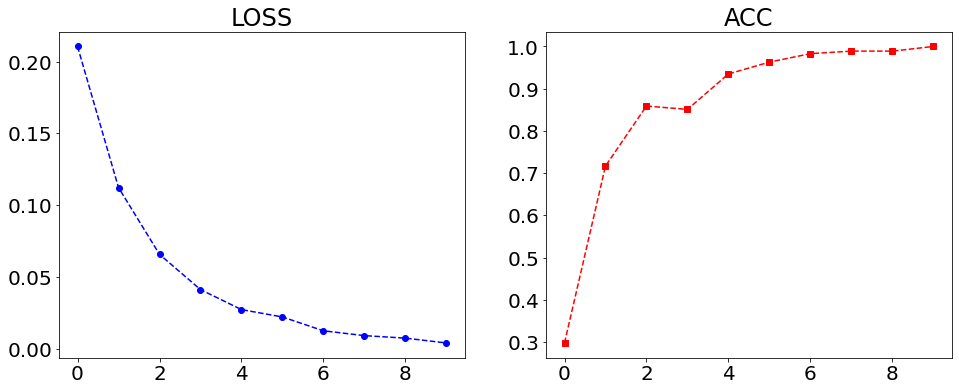

In [46]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(cnn1.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(cnn1.log_acc, 'rs--')